## 1. Focal Loss

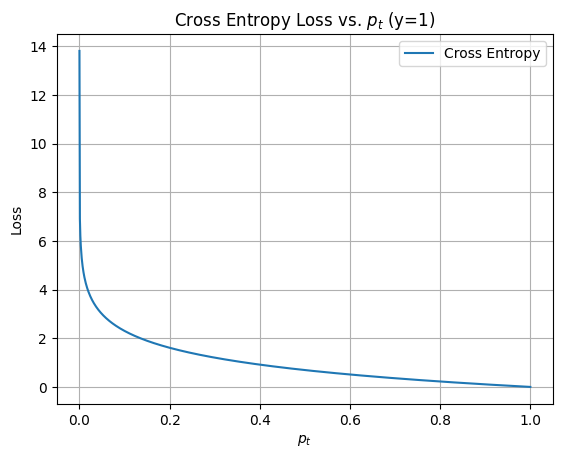

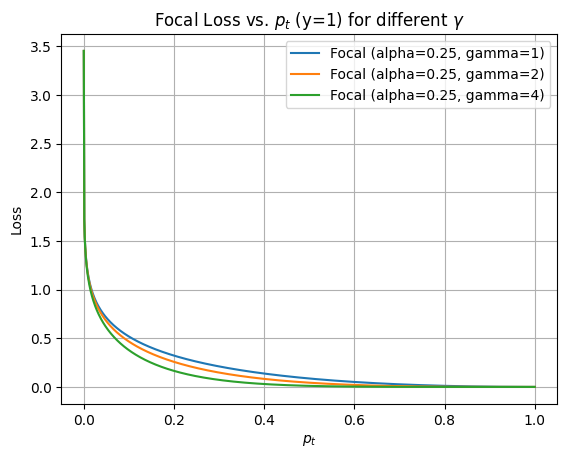

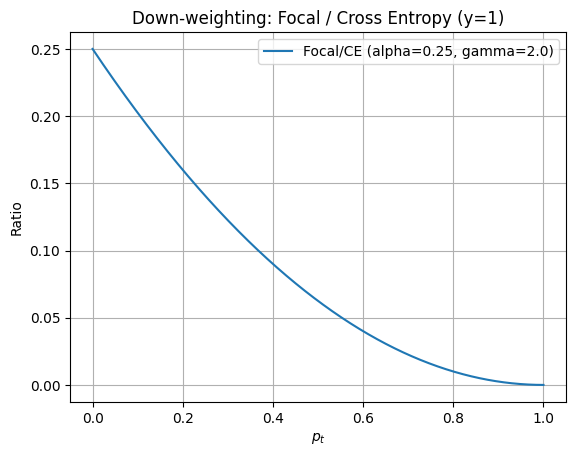

,p_t,CE,"Focal (a=0.25, g=1)","Focal (a=0.25, g=2)","Focal (a=0.25, g=4)",Focal/CE (g=2)
0,0.95,0.051293,0.000641,0.000032,0.000000,0.000625
1,0.70,0.356675,0.026751,0.008025,0.000722,0.022500
2,0.50,0.693147,0.086643,0.043322,0.010830,0.062500
3,0.10,2.302585,0.518082,0.466273,0.377682,0.202500


Saved CSV -> ce_vs_focal_examples.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log

# ---- losses ----
def ce_loss(pt):
    return -np.log(pt)

def focal_loss(pt, alpha=0.25, gamma=2.0):
    return -alpha * (1-pt)**gamma * np.log(pt)

# ---- domain ----
pt = np.linspace(1e-6, 1-1e-6, 1000)

# ---- plots ----
plt.figure()
plt.plot(pt, ce_loss(pt), label="Cross Entropy")
plt.title("Cross Entropy Loss vs. $p_t$ (y=1)")
plt.xlabel("$p_t$")
plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()

plt.figure()
for g in [1, 2, 4]:
    plt.plot(pt, focal_loss(pt, alpha=0.25, gamma=g), label=f"Focal (alpha=0.25, gamma={g})")
plt.title("Focal Loss vs. $p_t$ (y=1) for different $\\gamma$")
plt.xlabel("$p_t$"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()

alpha, gamma_ratio = 0.25, 2.0
ratio = focal_loss(pt, alpha=alpha, gamma=gamma_ratio) / ce_loss(pt)
plt.figure()
plt.plot(pt, ratio, label=f"Focal/CE (alpha={alpha}, gamma={gamma_ratio})")
plt.title("Down-weighting: Focal / Cross Entropy (y=1)")
plt.xlabel("$p_t$"); plt.ylabel("Ratio")
plt.legend(); plt.grid(True); plt.show()

# ---- table ----
example_pts = [0.95, 0.7, 0.5, 0.1]
rows = []
for p in example_pts:
    ce = -log(p)
    fl_g1 = -0.25 * (1-p)**1 * log(p)
    fl_g2 = -0.25 * (1-p)**2 * log(p)
    fl_g4 = -0.25 * (1-p)**4 * log(p)
    rows.append({
        "p_t": p,
        "CE": ce,
        "Focal (a=0.25, g=1)": fl_g1,
        "Focal (a=0.25, g=2)": fl_g2,
        "Focal (a=0.25, g=4)": fl_g4,
        "Focal/CE (g=2)": (fl_g2 / ce)
    })
df = pd.DataFrame(rows).round(6)

# ---- portable display ----
_displayed = False
try:
    # ChatGPT 전용 환경에서만 존재
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Loss comparison at selected p_t", df)
    _displayed = True
except Exception:
    try:
        # 일반 Jupyter/Colab
        from IPython.display import display
        display(df)
        _displayed = True
    except Exception:
        pass

if not _displayed:
    # 터미널/스크립트 환경
    print(df.to_string(index=False))

# ---- save csv ----
df.to_csv("ce_vs_focal_examples.csv", index=False)
print("Saved CSV -> ce_vs_focal_examples.csv")


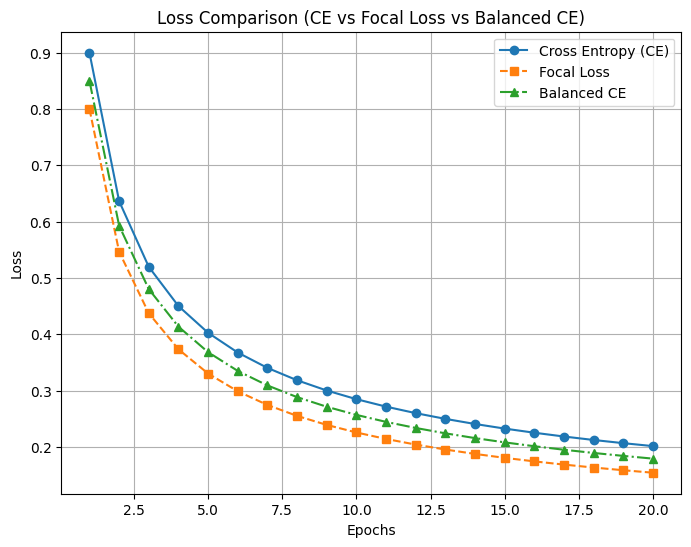

In [3]:
import matplotlib.pyplot as plt

# 예시 데이터 (사용자가 실제로 계산한 값 대신 임시로 생성)
epochs = list(range(1, 21))
ce_loss = [0.9/(i**0.5) for i in epochs]
focal_loss = [0.8/(i**0.55) for i in epochs]
balanced_ce = [0.85/(i**0.52) for i in epochs]

plt.figure(figsize=(8,6))
plt.plot(epochs, ce_loss, label="Cross Entropy (CE)", linestyle="-", marker="o")
plt.plot(epochs, focal_loss, label="Focal Loss", linestyle="--", marker="s")
plt.plot(epochs, balanced_ce, label="Balanced CE", linestyle="-.", marker="^")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison (CE vs Focal Loss vs Balanced CE)")
plt.legend()
plt.grid(True)
plt.show()


### 감마 조정

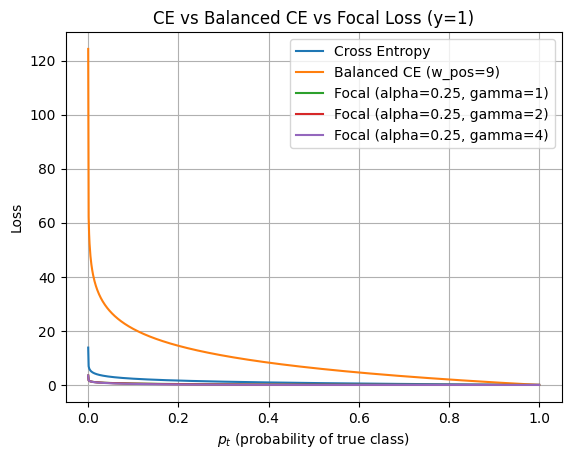

,p_t,CE,Balanced CE (w_pos=9),"Focal (a=0.25, g=1)","Focal (a=0.25, g=2)","Focal (a=0.25, g=4)"
0,0.95,0.051293,0.461640,0.000641,0.000032,0.000000
1,0.70,0.356675,3.210074,0.026751,0.008025,0.000722
2,0.50,0.693147,6.238325,0.086643,0.043322,0.010830
3,0.10,2.302585,20.723266,0.518082,0.466273,0.377682


Saved CSV -> \mnt\data\ce_bce_focal_comparison.csv
Saved Plot -> \mnt\data\ce_bce_focal_combined.png


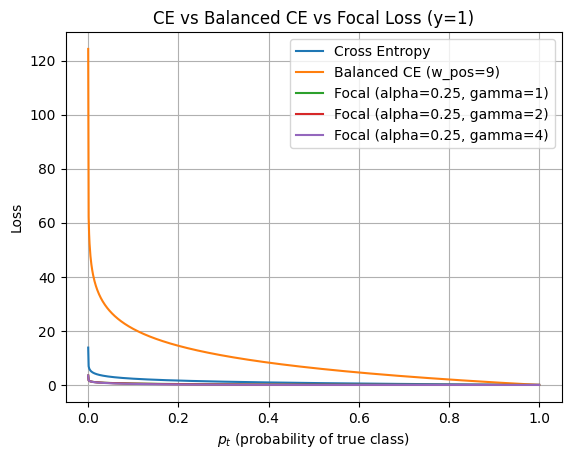

In [4]:
# CE vs Balanced CE vs Focal Loss on the same axes
# - CE(pt) = -log(pt)
# - Balanced CE for positive class (class-weighted BCE): BCE_pos(pt; w_pos) = -w_pos * log(pt)
# - Focal(pt; alpha, gamma) = -alpha * (1-pt)^gamma * log(pt)
#
# We will draw ONE figure with all curves on the SAME axes, as requested.
# We'll also create a small comparison table and save a CSV and the plot image for download.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log
from pathlib import Path

# ---- parameters (you can tweak these) ----
alpha = 0.25
gammas = [1, 2, 4]
# Assume a 1:9 imbalance (positive:negative = 1:9) -> w_pos ~= 9
w_pos = 9.0

# ---- definitions ----
def ce_loss(pt):
    return -np.log(pt)

def bce_weighted_pos(pt, w_pos=1.0):
    # Positive-class term of class-weighted BCE (y=1 case)
    return -w_pos * np.log(pt)

def focal_loss(pt, alpha=0.25, gamma=2.0):
    return -alpha * (1-pt)**gamma * np.log(pt)

# ---- domain ----
pt = np.linspace(1e-6, 1-1e-6, 1000)

# ---- combined plot ----
plt.figure()
plt.plot(pt, ce_loss(pt), label="Cross Entropy")
plt.plot(pt, bce_weighted_pos(pt, w_pos=w_pos), label=f"Balanced CE (w_pos={int(w_pos)})")
for g in gammas:
    plt.plot(pt, focal_loss(pt, alpha=alpha, gamma=g), label=f"Focal (alpha={alpha}, gamma={g})")
plt.title("CE vs Balanced CE vs Focal Loss (y=1)")
plt.xlabel("$p_t$ (probability of true class)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---- example table ----
example_pts = [0.95, 0.7, 0.5, 0.1]
rows = []
for p in example_pts:
    ce = -log(p)
    bce_pos = -w_pos * log(p)
    row = {
        "p_t": p,
        "CE": ce,
        f"Balanced CE (w_pos={int(w_pos)})": bce_pos,
    }
    for g in gammas:
        row[f"Focal (a={alpha}, g={g})"] = -alpha * (1-p)**g * log(p)
    rows.append(row)

df = pd.DataFrame(rows).round(6)

# Display (portable)
_displayed = False
try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("CE vs Balanced CE vs Focal (table)", df)
    _displayed = True
except Exception:
    try:
        from IPython.display import display
        display(df)
        _displayed = True
    except Exception:
        pass

if not _displayed:
    print(df.to_string(index=False))

# ---- save files ----
out_dir = Path("/mnt/data")
out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "ce_bce_focal_comparison.csv"
png_path = out_dir / "ce_bce_focal_combined.png"
df.to_csv(csv_path, index=False)

# Save the last shown figure again to file (re-plot to ensure consistent export)
plt.figure()
plt.plot(pt, ce_loss(pt), label="Cross Entropy")
plt.plot(pt, bce_weighted_pos(pt, w_pos=w_pos), label=f"Balanced CE (w_pos={int(w_pos)})")
for g in gammas:
    plt.plot(pt, focal_loss(pt, alpha=alpha, gamma=g), label=f"Focal (alpha={alpha}, gamma={g})")
plt.title("CE vs Balanced CE vs Focal Loss (y=1)")
plt.xlabel("$p_t$ (probability of true class)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(png_path, dpi=160, bbox_inches="tight")
print(f"Saved CSV -> {csv_path}")
print(f"Saved Plot -> {png_path}")


### 가중치 조정 

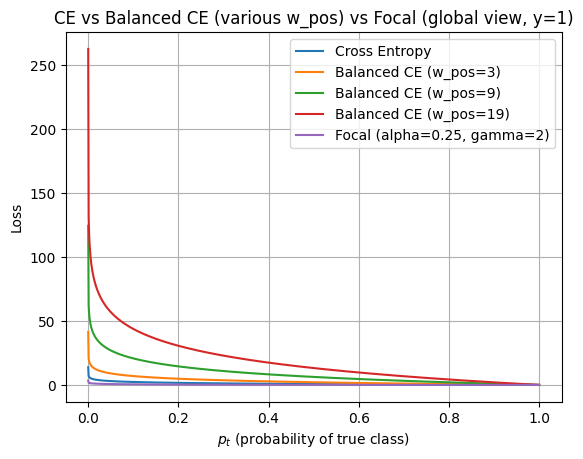

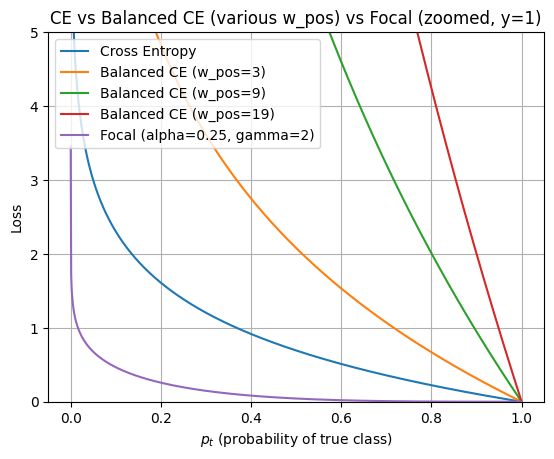

,p_t,CE,"Focal (a=0.25, g=2)",Balanced CE (w_pos=3),Balanced CE (w_pos=9),Balanced CE (w_pos=19)
0,0.95,0.051293,0.000032,0.153880,0.461640,0.974573
1,0.70,0.356675,0.008025,1.070025,3.210074,6.776824
2,0.50,0.693147,0.043322,2.079442,6.238325,13.169796
3,0.10,2.302585,0.466273,6.907755,20.723266,43.749117


Saved CSV -> \mnt\data\ce_bce_focal_adjusted_weights.csv
Saved Plots -> \mnt\data\ce_bce_focal_adjusted_global.png and \mnt\data\ce_bce_focal_adjusted_zoom.png


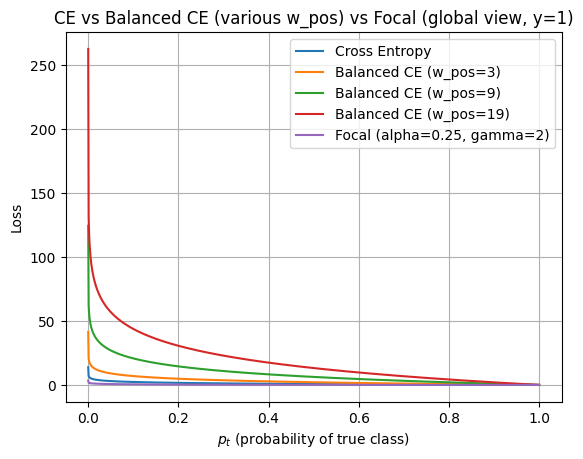

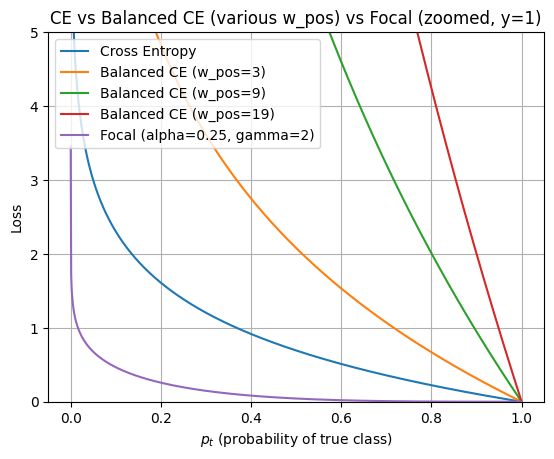

In [5]:
# Adjusted class weights (w_pos) for Balanced CE, re-plot on the same axes
# We'll show:
#   (1) Global view: CE vs Balanced CE (w_pos in [3, 9, 19]) vs Focal (alpha=0.25, gamma=2)
#   (2) Zoomed view: same curves but y-limits tightened to highlight differences near easy samples
#   (3) Table at selected p_t values
# and save CSV + PNGs.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log
from pathlib import Path

# Parameters
alpha = 0.25
gamma = 2.0
w_pos_list = [3.0, 9.0, 19.0]  # adjusted class weights for positive class

def ce_loss(pt):
    return -np.log(pt)

def bce_weighted_pos(pt, w_pos=1.0):
    # Positive-class term of class-weighted BCE (y=1 case)
    return -w_pos * np.log(pt)

def focal_loss(pt, alpha=0.25, gamma=2.0):
    return -alpha * (1-pt)**gamma * np.log(pt)

# Domain
pt = np.linspace(1e-6, 1-1e-6, 1000)

# Figure 1: Global view
plt.figure()
plt.plot(pt, ce_loss(pt), label="Cross Entropy")
for w in w_pos_list:
    plt.plot(pt, bce_weighted_pos(pt, w_pos=w), label=f"Balanced CE (w_pos={int(w)})")
plt.plot(pt, focal_loss(pt, alpha=alpha, gamma=gamma), label=f"Focal (alpha={alpha}, gamma={int(gamma)})")
plt.title("CE vs Balanced CE (various w_pos) vs Focal (global view, y=1)")
plt.xlabel("$p_t$ (probability of true class)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Figure 2: Zoomed view (to see differences around easy/moderate p_t)
plt.figure()
plt.plot(pt, ce_loss(pt), label="Cross Entropy")
for w in w_pos_list:
    plt.plot(pt, bce_weighted_pos(pt, w_pos=w), label=f"Balanced CE (w_pos={int(w)})")
plt.plot(pt, focal_loss(pt, alpha=alpha, gamma=gamma), label=f"Focal (alpha={alpha}, gamma={int(gamma)})")
plt.title("CE vs Balanced CE (various w_pos) vs Focal (zoomed, y=1)")
plt.xlabel("$p_t$ (probability of true class)")
plt.ylabel("Loss")
plt.ylim(0, 5)  # zoom
plt.legend()
plt.grid(True)
plt.show()

# Table at selected points
example_pts = [0.95, 0.7, 0.5, 0.1]
rows = []
for p in example_pts:
    row = {"p_t": p, "CE": -log(p), f"Focal (a={alpha}, g={int(gamma)})": -alpha * (1-p)**gamma * log(p)}
    for w in w_pos_list:
        row[f"Balanced CE (w_pos={int(w)})"] = -w * log(p)
    rows.append(row)
df = pd.DataFrame(rows).round(6)

# Portable display
_displayed = False
try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Adjusted Weights: CE vs Balanced CE vs Focal (table)", df)
    _displayed = True
except Exception:
    try:
        from IPython.display import display
        display(df)
        _displayed = True
    except Exception:
        pass
if not _displayed:
    print(df.to_string(index=False))

# Save outputs
out_dir = Path("/mnt/data")
out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "ce_bce_focal_adjusted_weights.csv"
png_global = out_dir / "ce_bce_focal_adjusted_global.png"
png_zoom = out_dir / "ce_bce_focal_adjusted_zoom.png"
df.to_csv(csv_path, index=False)

# Re-plot for saving to files
plt.figure()
plt.plot(pt, ce_loss(pt), label="Cross Entropy")
for w in w_pos_list:
    plt.plot(pt, bce_weighted_pos(pt, w_pos=w), label=f"Balanced CE (w_pos={int(w)})")
plt.plot(pt, focal_loss(pt, alpha=alpha, gamma=gamma), label=f"Focal (alpha={alpha}, gamma={int(gamma)})")
plt.title("CE vs Balanced CE (various w_pos) vs Focal (global view, y=1)")
plt.xlabel("$p_t$ (probability of true class)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(png_global, dpi=160, bbox_inches="tight")

plt.figure()
plt.plot(pt, ce_loss(pt), label="Cross Entropy")
for w in w_pos_list:
    plt.plot(pt, bce_weighted_pos(pt, w_pos=w), label=f"Balanced CE (w_pos={int(w)})")
plt.plot(pt, focal_loss(pt, alpha=alpha, gamma=gamma), label=f"Focal (alpha={alpha}, gamma={int(gamma)})")
plt.title("CE vs Balanced CE (various w_pos) vs Focal (zoomed, y=1)")
plt.xlabel("$p_t$ (probability of true class)")
plt.ylabel("Loss")
plt.ylim(0, 5)
plt.legend()
plt.grid(True)
plt.savefig(png_zoom, dpi=160, bbox_inches="tight")

print(f"Saved CSV -> {csv_path}")
print(f"Saved Plots -> {png_global} and {png_zoom}")
